In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as clrs
import sklearn
from time import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#%matplotlib widget
#%matplotlib qt

# Make classification

In [9]:
X,y=make_classification(n_samples=1500,
                        n_features=2,
                        n_clusters_per_class=1,
                        n_informative=2,
                        n_redundant=0,
                        n_classes=4,
                        random_state=0)
labels=np.unique(y)

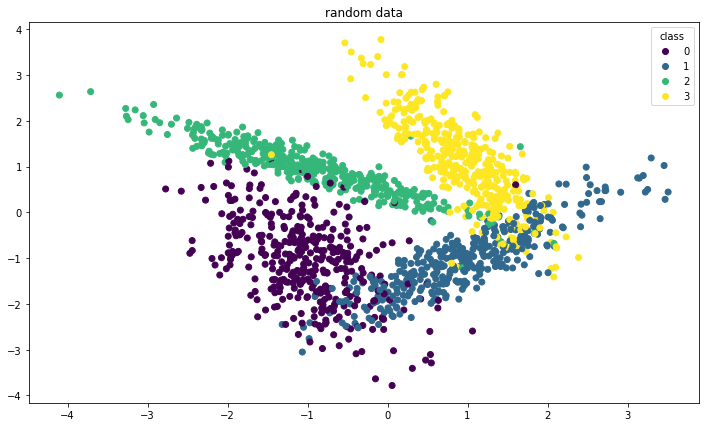

In [10]:
fig,ax=plt.subplots(1,1,figsize=(12,7))

ax.set_title('random data')
scat=ax.scatter(X[:,0],X[:,1],c=y)

plt.legend(handles=scat.legend_elements()[0], labels=labels.tolist(), title="class")

plt.show()

# Choose classificators

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize


classificators=[SVC(kernel='linear', probability=True),
                SVC(kernel='rbf', probability=True),
                LogisticRegression(),
                Perceptron()]

strategy={'ovr':OneVsRestClassifier,
          'ovo':OneVsOneClassifier}


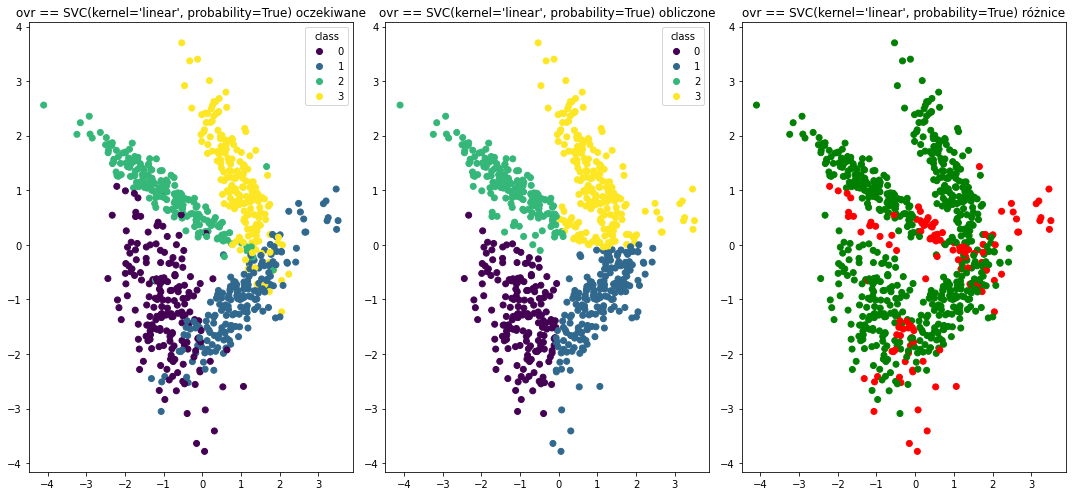

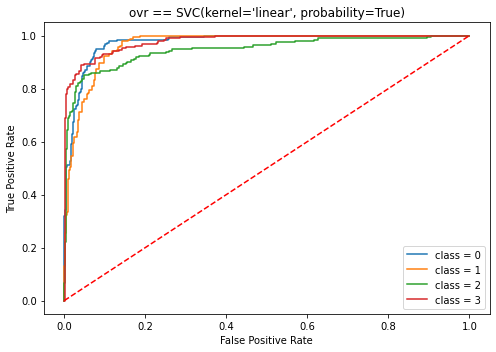

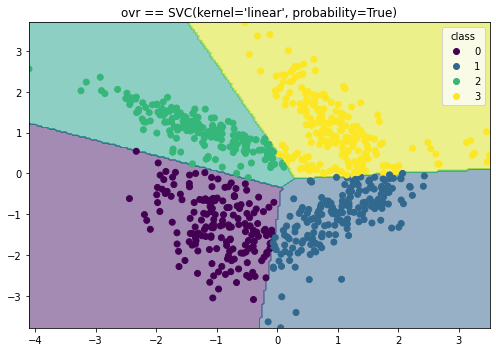

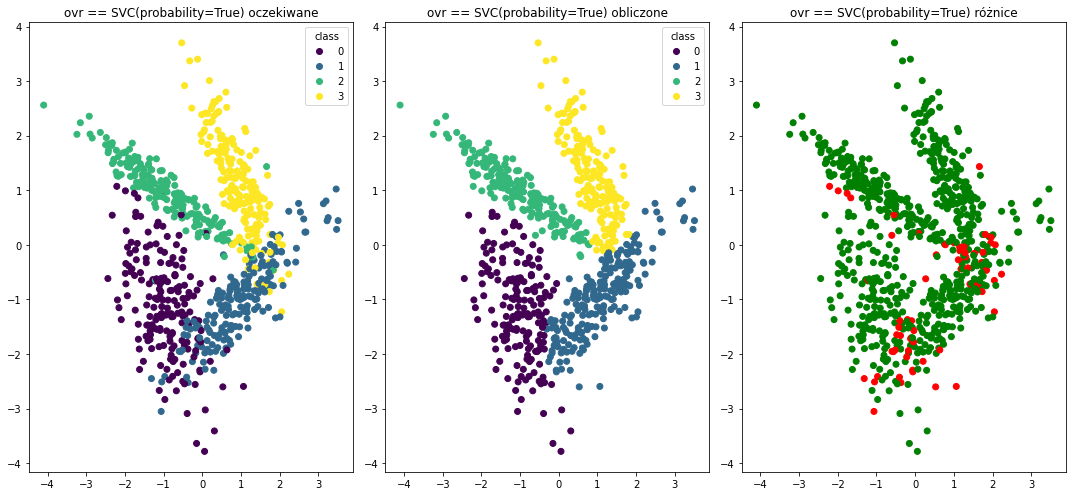

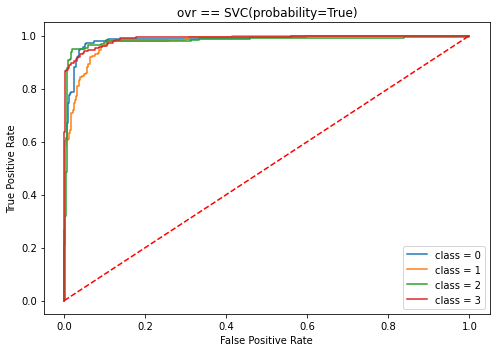

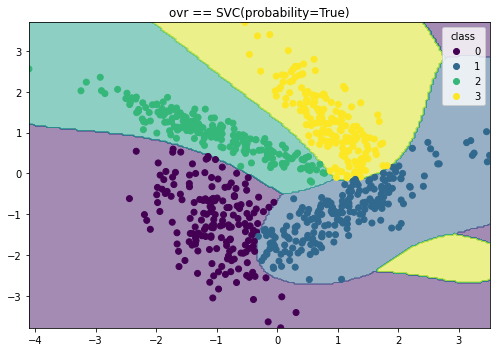

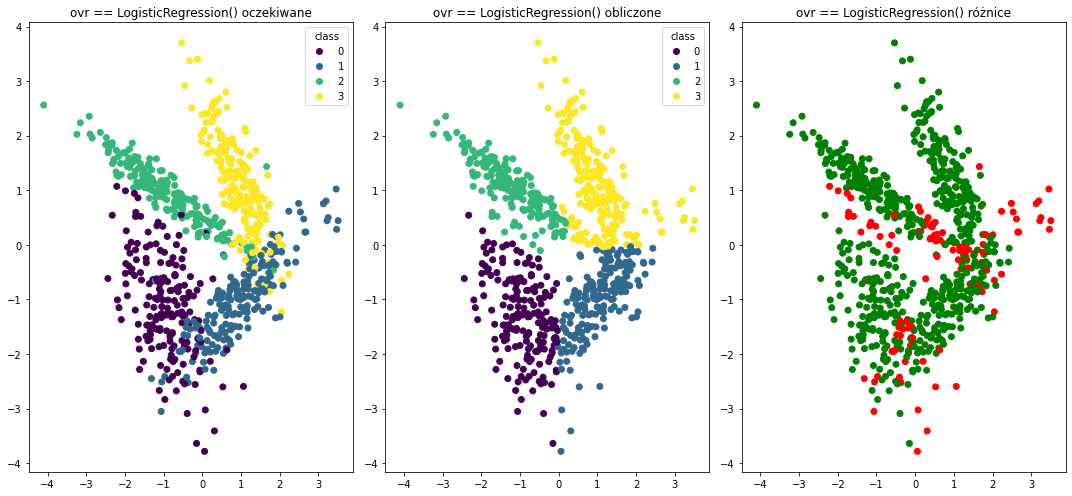

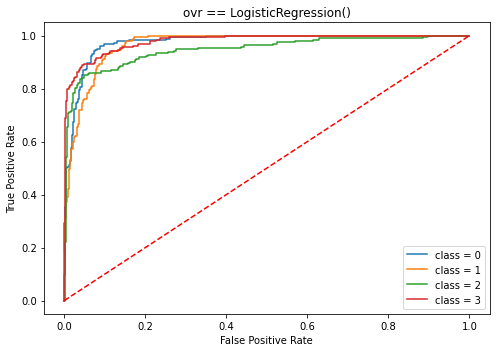

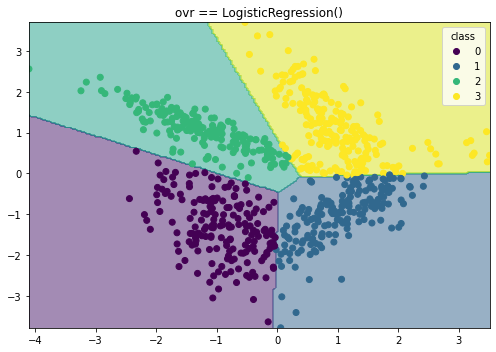

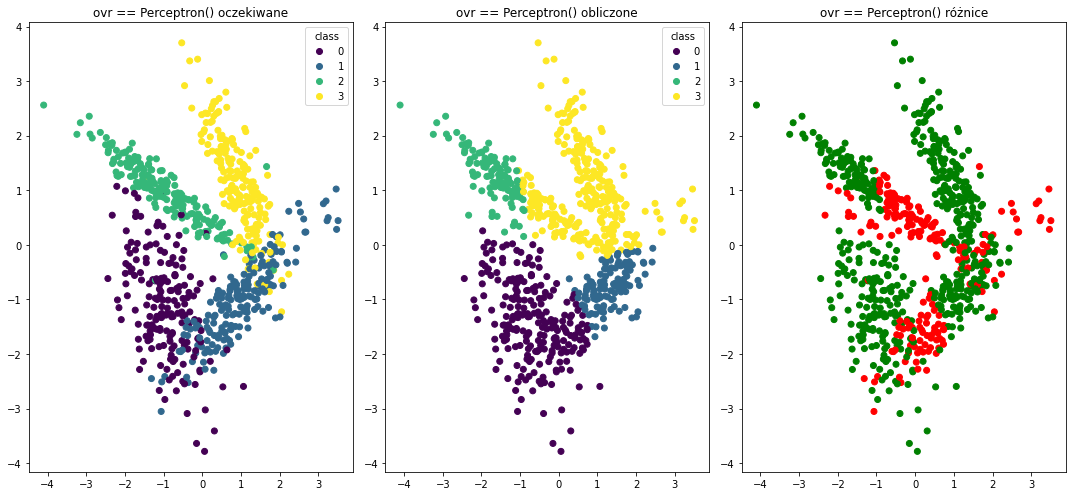

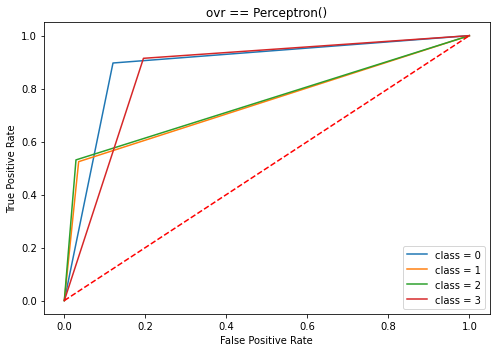

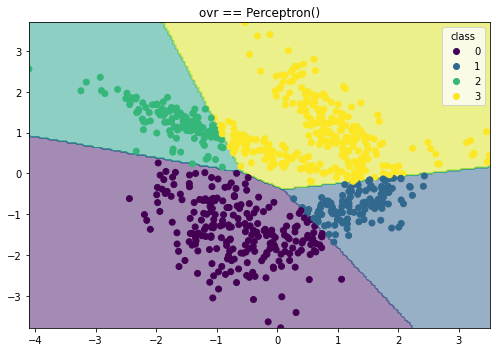

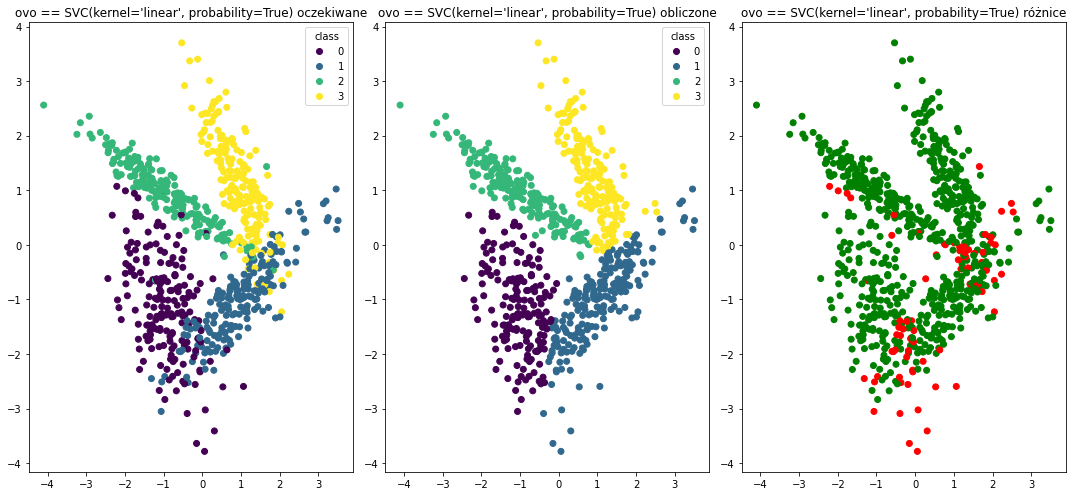

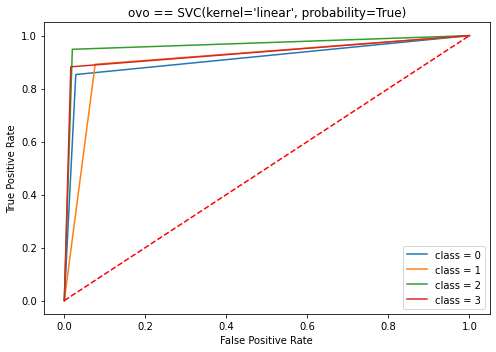

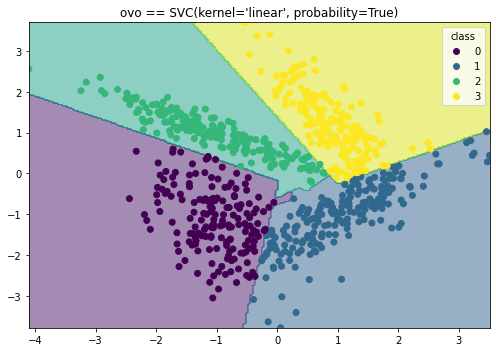

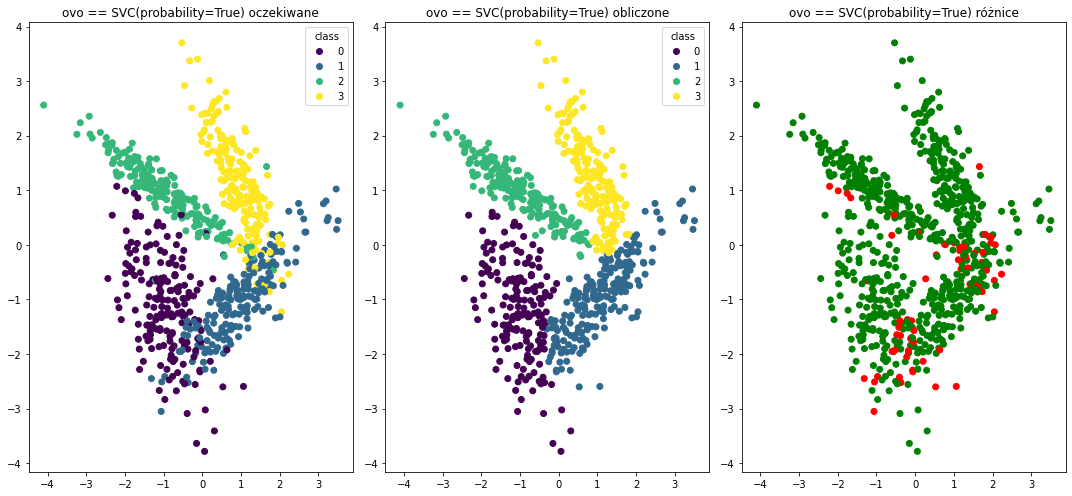

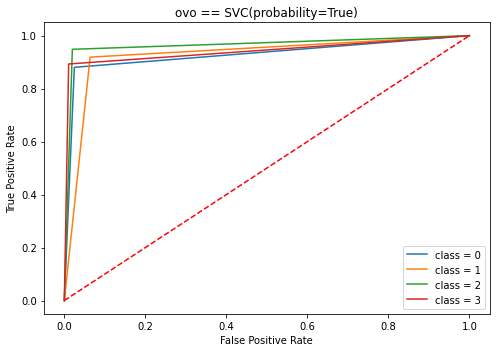

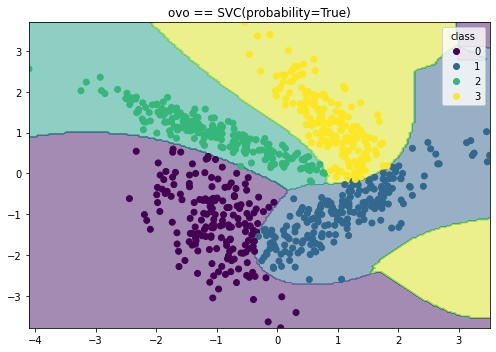

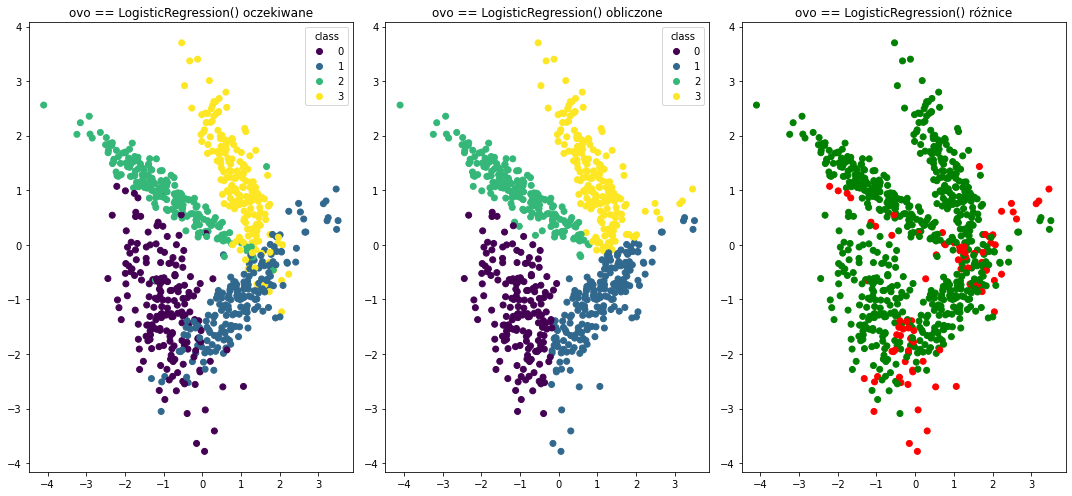

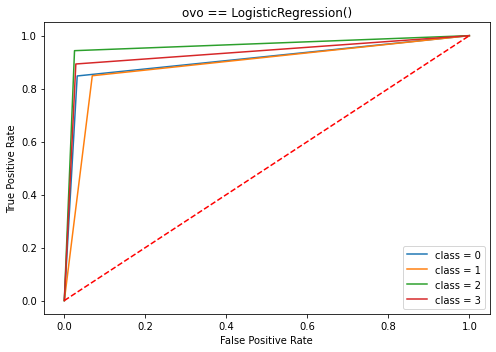

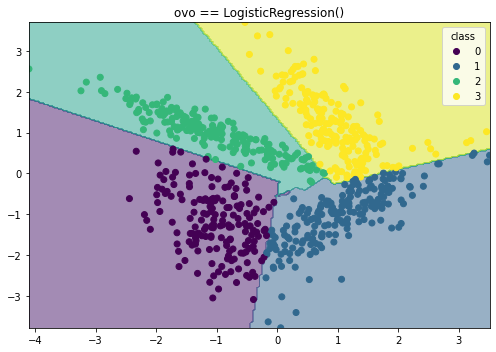

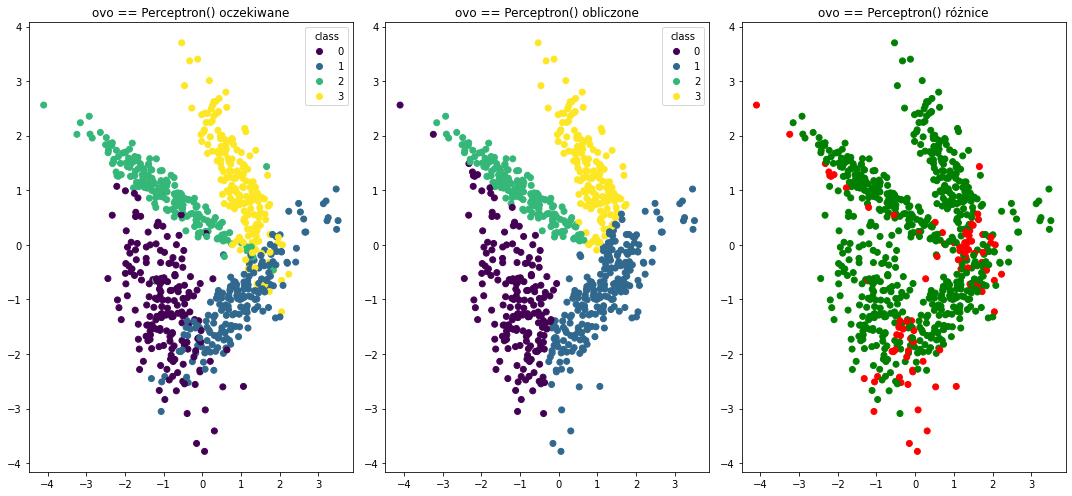

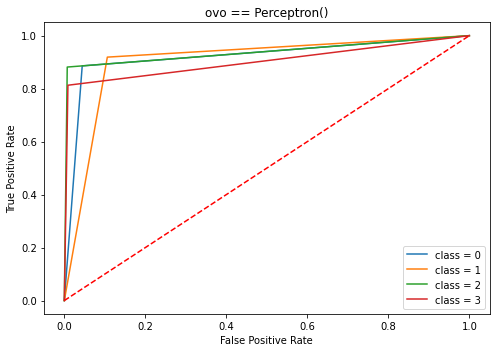

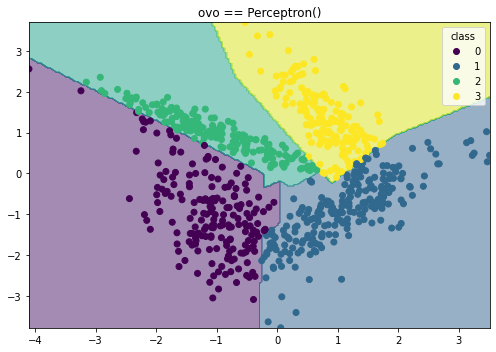

In [12]:
n_iters=10

df=pd.DataFrame()

for strat in strategy:

    for i in range(len(classificators)):
        
        for j in range(n_iters):
            cls=strategy[strat](classificators[i])
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
            
            t1=time()
            cls.fit(X_train, y_train)
            fit_time=time()-t1
            
            t1=time()
            y_pred=cls.predict(X_test)
            pred_time=time()-t1
            
            acc=accuracy_score(y_test,y_pred)
            rec=recall_score(y_test,y_pred, average='weighted')
            prec=precision_score(y_test,y_pred, average='weighted')
            f1=f1_score(y_test,y_pred, average='weighted')
        
            y_test_bin=label_binarize(y_test, classes=labels)
            y_pred_bin=label_binarize(y_pred, classes=labels)
            
            roc=roc_auc_score(y_test_bin,
                            y_pred_bin,
                            multi_class=strat)
            
            
            name=f'{strat} == {classificators[i]}'
            
            row=pd.Series(
                        {'function':name,
                         'n_iter': j,
                         'fit_time':fit_time,
                         'pred_time':pred_time,
                         'acc':acc,
                         'rec':rec,
                         'prec':prec,
                         'f1':f1,
                         'roc':roc}
        )
        df=df.append(row, ignore_index=True)
            
        fig,ax=plt.subplots(1,3,figsize=(15,7))
            
        ax[0].set_title(f'{name} oczekiwane')
        scat1=ax[0].scatter(X_test[:,0],X_test[:,1],c=y_test)
        ax[0].legend(handles=scat1.legend_elements()[0], labels=labels.tolist(), title="class")
        
        ax[1].set_title(f'{name} obliczone')
        scat2=ax[1].scatter(X_test[:,0],X_test[:,1],c=y_pred)
        ax[1].legend(handles=scat2.legend_elements()[0], labels=labels.tolist(), title="class")
        
        ax[2].set_title(f'{name} różnice')
        scat3=ax[2].scatter(X_test[:,0],X_test[:,1],c=y_test==y_pred,cmap = clrs.ListedColormap(['red', 'green']))
        
        
        fig.tight_layout()
        plt.show()
        
        #roc_curve
        fig,ax=plt.subplots(1,1,figsize=(7,5))

        ax.set_title(f'{name}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        
        try:
            y_score = cls.predict_proba(X_test)
        except:
            y_score=y_pred_bin
        
        for i in range(len(labels)):
            
            fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score[:,i])
            ax.plot(fpr,tpr,label=f'class = {i}')

        ax.plot([fpr[0],fpr[-1]], [tpr[0],tpr[-1]],"r--")
        ax.legend()
        fig.tight_layout()
        plt.show()
        
        #differences
        
        fig,ax=plt.subplots(1,1,figsize=(7,5))
        n_points=200
        mesh=np.meshgrid(np.linspace(min(X_test[:,0]),max(X_test[:,0]),n_points) , np.linspace(min(X_test[:,1]),max(X_test[:,1]),n_points))
        data = np.vstack([mesh[0].ravel(),mesh[1].ravel()]).T
        
        predicted=cls.predict(data).reshape(n_points,n_points)
        
        ax.set_title(f'{name}')
        ax.contourf(mesh[0], mesh[1], predicted, alpha=0.5)
        scat=ax.scatter(X_test[:,0], X_test[:,1], c=y_pred)
        ax.legend(handles=scat.legend_elements()[0], labels=labels.tolist(), title="class")
        
        fig.tight_layout()
        plt.show()
    

plt.show()

In [13]:
final=df.groupby(['function']).mean().drop('n_iter',axis=1)
final.sort_values(by="roc",ascending=False)

,fit_time,pred_time,acc,rec,prec,f1,roc
function,,,,,,,
ovo == SVC(probability=True),0.046878,0.053859,0.910667,0.910667,0.914139,0.911321,0.940245
ovr == SVC(probability=True),0.103725,0.030912,0.909333,0.909333,0.913106,0.910029,0.939356
"ovo == SVC(kernel='linear', probability=True)",0.031912,0.010973,0.894667,0.894667,0.898829,0.895533,0.929477
ovo == LogisticRegression(),0.027925,0.001994,0.884000,0.884000,0.885357,0.884301,0.922299
ovo == Perceptron(),0.007979,0.001997,0.874667,0.874667,0.889175,0.877166,0.916578
ovr == LogisticRegression(),0.014960,0.000000,0.842667,0.842667,0.844270,0.842494,0.895080
"ovr == SVC(kernel='linear', probability=True)",0.096717,0.010972,0.832000,0.832000,0.834988,0.832182,0.888015
ovr == Perceptron(),0.005985,0.000998,0.714667,0.714667,0.753853,0.705049,0.810841


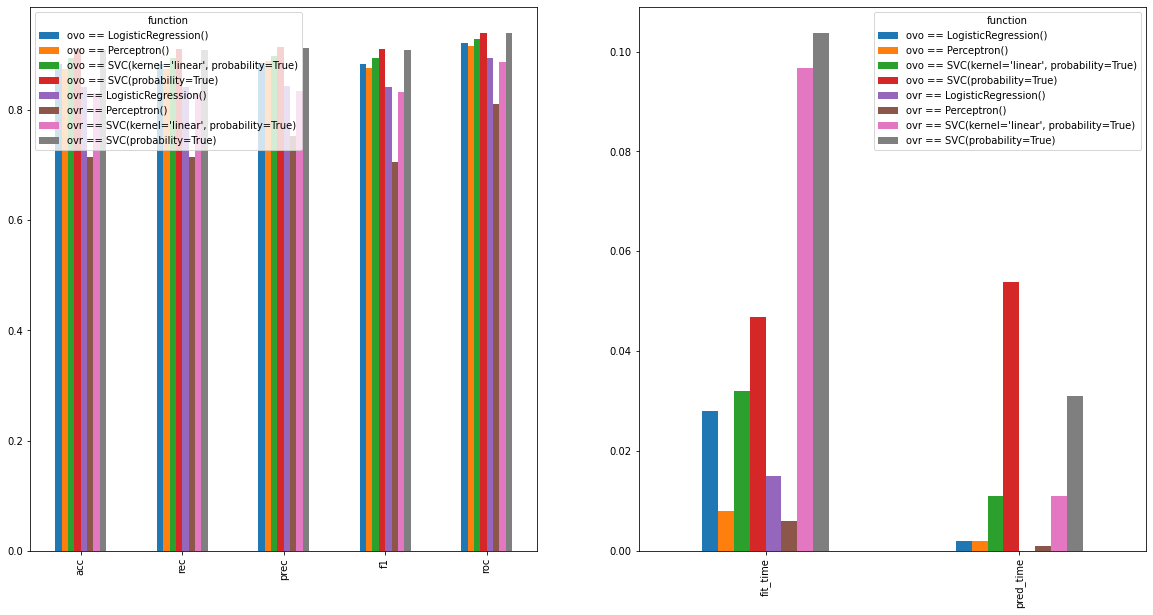

In [14]:
fig,ax=plt.subplots(1,2,figsize=(20,10))

final[['acc', 'rec', 'prec', 'f1', 'roc']].T.plot(kind='bar',ax=ax[0])
final[['fit_time', 'pred_time']].T.plot(kind='bar',ax=ax[1])

plt.show()